# Summary

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import shap
import os
import pickle
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import norm, chi2

# the following packages need to be imported into the site-packages folder
from config import properties as p
from src.utils import utils as u

In [2]:
def read_report(report_name: str, highlight : bool = True):
    report = pd.read_csv(os.path.join(p.model_evaluation_report_compiled_path, report_name))
    report.columns = ["metrics"] + report.columns.tolist()[1:]
    model_col = report.columns[1:].tolist()
    report[model_col] = report[model_col].apply(lambda x: round(x, 2))

    report = report.T
    report = report.rename(columns=report.iloc[0])
    report = report.drop(report.index[0])
    
    if highlight:
        report = report.style.highlight_max(color = 'lightgreen', axis = 0)
    display(report) 

In [3]:
all_shap_filename = os.listdir(p.shap_path)
all_shap = [u.load_model(os.path.join(p.shap_path, f)) for f in all_shap_filename if '.pkl' in f]

In [4]:
all_model_filename = [f for f in os.listdir(p.model_path) if '.pkl' in f]
all_model = [u.load_model(os.path.join(p.model_path, f)) for f in all_model_filename if '.pkl' in f]

## Predictibility of the VIX-based RSI measure

### 1. Model Reliability

In [5]:
read_report("train_compiled_report.csv")

,Train_Accuracy,Train_F1-Score,Train_Precision,Train_ROC_AUC_Score,Train_Recall
ANN,0.630000,0.600000,0.750000,0.690000,0.500000
Ensemble_Stacking,0.440000,0.000000,0.000000,0.710000,0.000000
Ensemble_Voting,0.540000,0.330000,0.900000,0.750000,0.210000
LightGBM,0.590000,0.530000,0.760000,0.710000,0.400000
Logistic,0.460000,0.250000,0.590000,0.550000,0.160000
LSTM,0.630000,0.610000,0.770000,0.710000,0.500000
RandomForest,0.480000,0.150000,0.960000,0.780000,0.080000
XGBoost,0.590000,0.510000,0.800000,0.710000,0.370000


The following metrics are commonly used to evaluate a classification model's predictive performance - Accuracy, Precision, Recall, F1-Score and ROC score.

Accuracy is defined as:
\begin{equation}
Acc = \frac{tp + tn}{tp + tn + fp + fn}
\end{equation}

Precision is defined as:
\begin{equation}
Precision = \frac{tp}{tp + fp}
\end{equation}

Recall is defined as:
\begin{equation}
Recall = \frac{tp}{tp + fn}
\end{equation}

F1-Score is defined as:
\begin{equation}
F1 = \frac{precision*recall}{precision+recall} = \frac{tp}{tp + 0.5(fp+fn)}
\end{equation}

ROC is defined as:
\begin{equation}
AUC = \int TPR \; d(FPR)
\end{equation}

where 

\begin{equation}
TPR = \frac{tp}{tp + fn}
\end{equation}

From the above table, we can see that LSTM perform the best in all metrics. 

### 2. Significance of the VIX-based RSI measure

#### Logistic Regression

In [6]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

In [7]:
# Logistic Regression

logistic_reg = u.load_model(os.path.join(p.model_path, "Logistic.pkl"))
x_col = ["RSI", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7"]
y_col = ["target"]
x_train = pd.read_csv(p.train_set_path)[x_col]
y_train = pd.read_csv(p.train_set_path)[y_col]
logit_pvalue(logistic_reg, x_train)[0]

0.7433619246248517

As p-value not less than 0.05, we do not reject the null hypothesis that RSI is not significant.

#### Random Forest

In [8]:
def tree_variable_importance(ind: int):
    var_importance = zip(x_col, all_model[ind].best_estimator_.feature_importances_)
    var_importance = sorted(var_importance, key=lambda x: x[1], reverse=True)
    x, val = [elem[0] for elem in var_importance], [elem[1] for elem in var_importance]

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.barh(x, val, color='dodgerblue')
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(f"{all_model_filename[ind]} Feature Importance")
    plt.show()

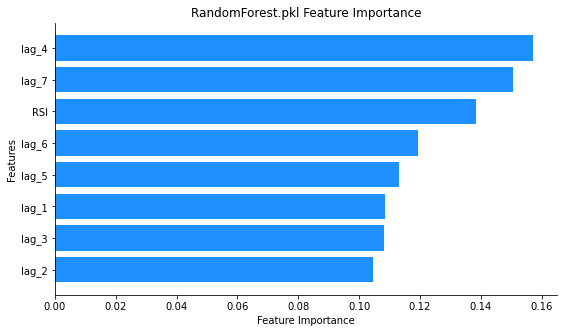

In [9]:
tree_variable_importance(6)

#### LightGBM

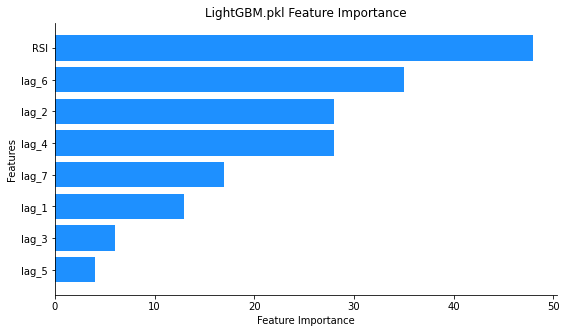

In [10]:
tree_variable_importance(3)

#### XGBoost

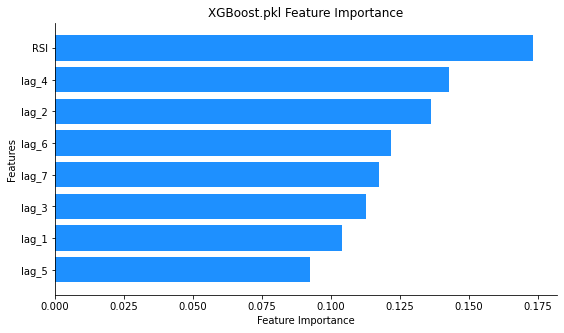

In [11]:
tree_variable_importance(-1)

#### ANN

In [12]:
def nn_variable_importance(ind: int):
    shap.summary_plot(all_shap[ind], plot_type="bar", show=False)
    plt.title(f"{all_shap_filename[ind]} Feature Importance")
    plt.show()

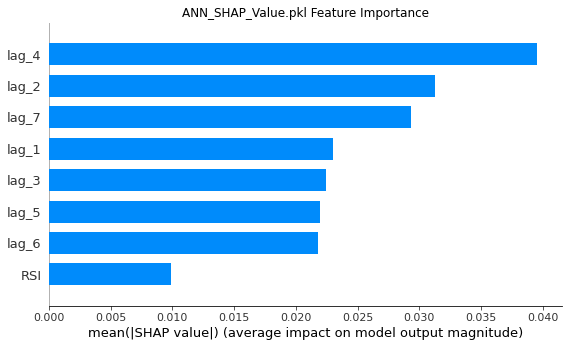

In [13]:
nn_variable_importance(0)

#### LSTM

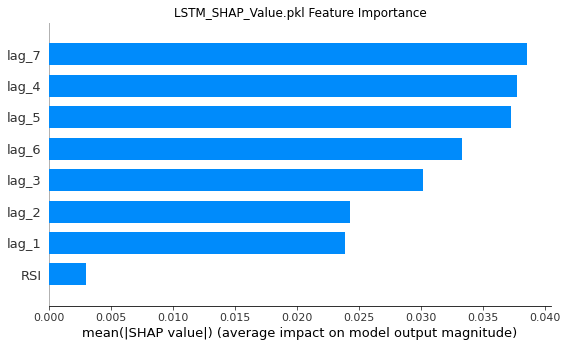

In [15]:
nn_variable_importance(5)

#### Ensemble - Stacking

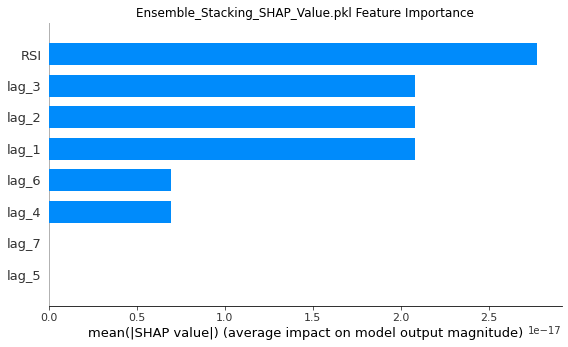

In [16]:
nn_variable_importance(1)

#### Ensemble - Voting

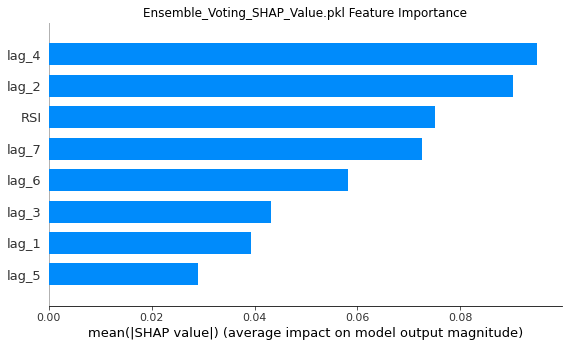

In [17]:
nn_variable_importance(2)

#### Significance of RSI - Findings

Overall, RSI is deemed as a significant variable in modelling the next day stock movement. This is evident as RSI is the top 3 feature of most models.

The following models are the exception:
1. Logistic Regression - with a p-value of 0.7, we do not reject the null hypothesis that RSI is significant.
2. ANN and LSTM - RSI is the least important feature (via SHAP value).

### 3. Impact of the VIX-based RSI measure on the prediction

The log-odds equation is defined as:
\begin{equation}
f(X) = X \beta + \epsilon
\end{equation}

Logistic Regression is defined as:
\begin{equation}
y = \frac{1}{1 + e^{- f(X)}}
\end{equation}

In [18]:
# logistic regression
logistic_reg = u.load_model(os.path.join(p.model_path, "Logistic.pkl"))
print(f"The coefficient of RSI is {logistic_reg.coef_[0][0]:.2f}")

The coefficient of RSI is 0.15


In [19]:
def log_reg(rsi: float) -> float:
    return 1/(1+np.exp(-logistic_reg.coef_[0][0]*rsi))

def diff_log_reg(base: list, change:float) -> list:
    return [log_reg(x+change_in_RSI) - log_reg(x) for x in base]

In [20]:
change_in_RSI = 1
base = list(np.linspace(0, 4, num=10))
impact = diff_log_reg(base, change_in_RSI)

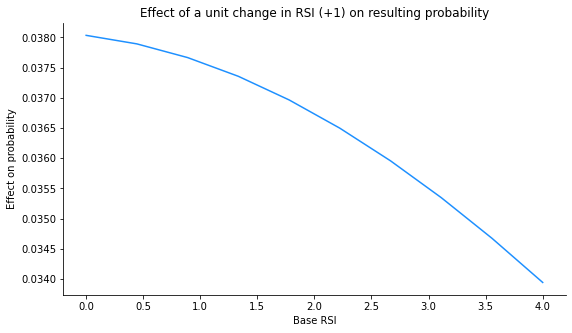

In [21]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(base, impact, color='dodgerblue')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Base RSI")
plt.ylabel("Effect on probability")
plt.title(f"Effect of a unit change in RSI (+{change_in_RSI}) on resulting probability")
plt.show()

As RSI increases by 1, the probability increases by around 0.03. 

The reason for the diminishing impact of RSI on the predicted outcome:
1. A high RSI measure would yield a higher probability (ceteris paribus)
2. As probability can only cap at 1 ($0 \leq p \leq 1$), the impact of RSI on the predicted outcome will decrease.

In [22]:
def shap_plot(ind: int):
    shap.summary_plot(all_shap[ind], show=False)
    plt.title(f"{all_shap_filename[ind]} Shap Value Summary")
    plt.show()

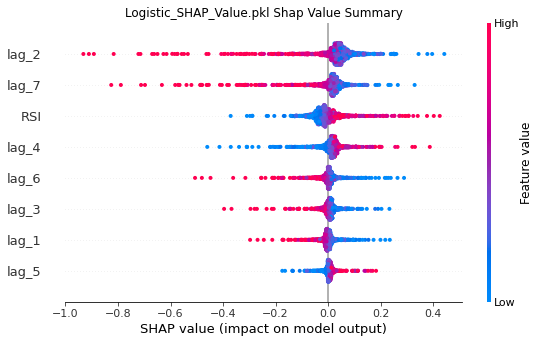

In [23]:
shap_plot(4)

Blue represents low feature value and red represents high feature value. 
shap_individual_plot(6)
We can spot the following general observations:
1. High RSI value (red) have positive SHAP value (impact on model output)
2. Low RSI value (blue) have negative SHAP value (impact on model outpot)

In [24]:
def shap_individual_plot(ind: int):
    shap.plots.waterfall(all_shap[ind][0], show=False)
    plt.title(f"{all_shap_filename[ind]} Shap Value Waterfall Plot")
    plt.show()

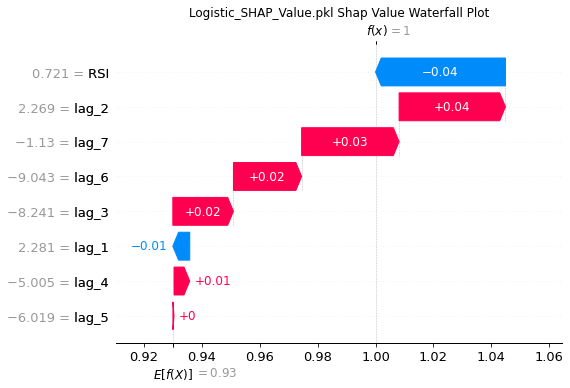

In [25]:
shap_individual_plot(4)

This is a plot of how the first data point in the training set arrive at its prediction. 

We can see that:
1. RSI of 0.721 result in a drop in probability by 0.04.
2. 

In [26]:
def shap_scatter_plot(ind: int):
    fig, ax = plt.subplots(figsize=(9, 5))
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['dodgerblue', np.array([255, 13, 87]) / 255], N=5)
    x = [elem[0] for elem in all_shap[ind].data]
    y = [elem[0] for elem in all_shap[ind].values]
    plt.scatter(x, y, marker='.', c=x, cmap=cmap)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f"[{all_shap_filename[ind]}] Impact of RSI on Model Prediction")
    plt.xlabel("RSI")
    plt.ylabel("SHAP Value")
    plt.show()

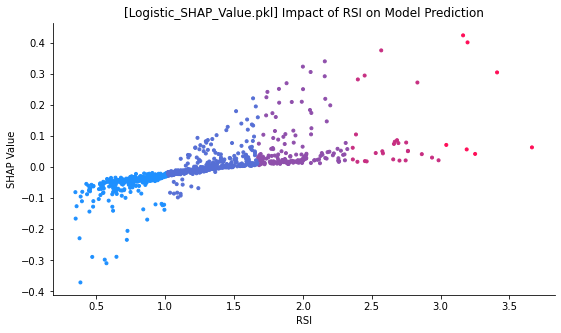

In [27]:
shap_scatter_plot(4)

We generated a scatter plot of RSI against SHAP value (impact on the model prediction). 

We note the following:
1. RSI has a linear impact on the model prediction
2. The higher the RSI, the more likely the next day returns will be positive
3. Positive RSI will have a positive impact on the outcome and negative RSI will havhe a negative impact on the outcome.

#### Random Forest

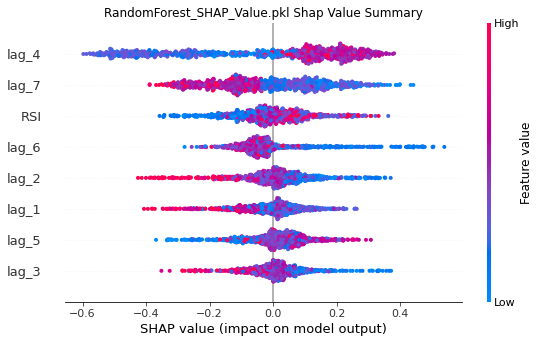

In [28]:
shap_plot(6)

We can spot the following general observations:
1. High RSI value (red) have positive SHAP value (impact on model output)
2. Low RSI value (blue) have negative SHAP value (impact on model outpot)

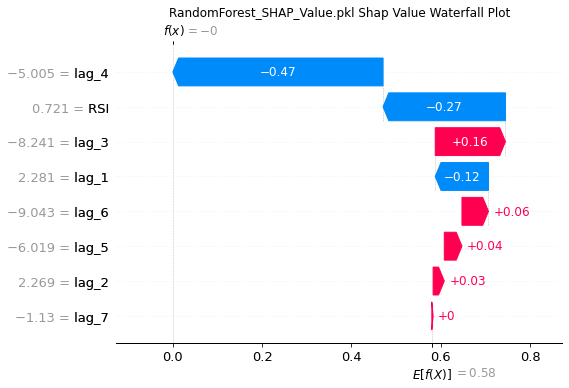

In [29]:
shap_individual_plot(6)

From here, we can spot that:
1. This data point has a low RSI value of 0.721.
2. RSI = 0.721 will cause the probability of positive returns to drop by 0.27.

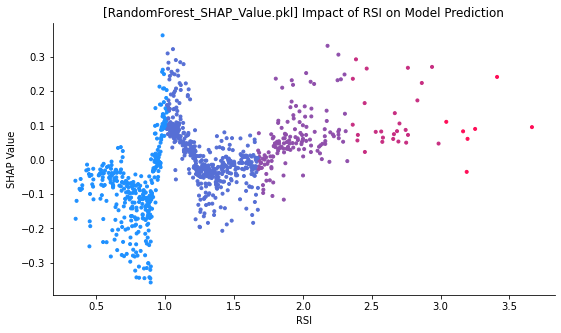

In [30]:
shap_scatter_plot(6)

We note the following:
1. RSI has a non-linear impact on the model prediction (expected of a tree based model). 
2. A RSI of 1 or higher than 2 indicates that the next day return will likely be positive.

#### LightGBM

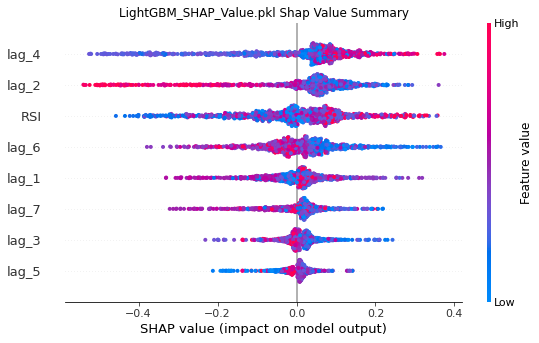

In [31]:
shap_plot(3)

We can spot the folloshap_individual_plotwing general observations:
1. High RSI value (red) have positive SHAP value (impact on model output)
2. Low RSI value (blue) have negative SHAP value (impact on model outpot)

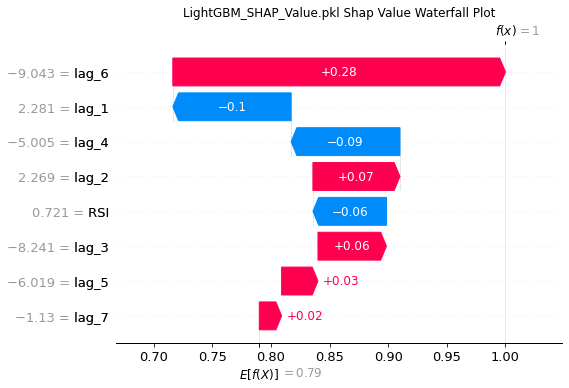

In [32]:
shap_individual_plot(3)

From here, we can spot that:
1. This data point has a low RSI value of 0.721.
2. RSI = 0.721 will cause the probability of positive returns to drop by 0.06.

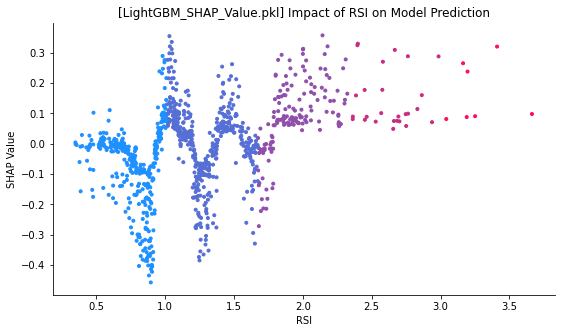

In [33]:
shap_scatter_plot(3)

We note the following:
1. RSI has a non-linear impact on the model prediction (expected of a tree based model). 
2. A RSI of 1, 1.5 or higher than 2 indicates that the next day return will likely be positive.

#### XGBoostshap_plot

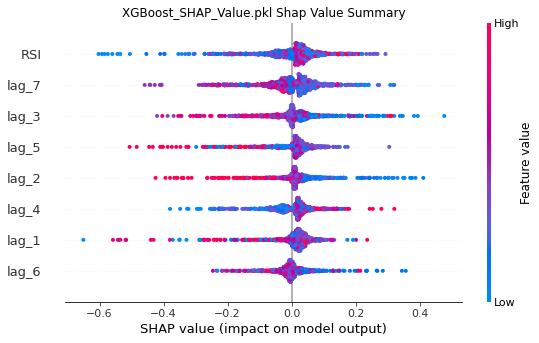

In [34]:
shap_plot(-1)

We can spot the following general observations:
1. High RSI value (red) have positive SHAP value (impact on model output)
2. Low RSI value (blue) have negative SHAP value (impact on model outpot)

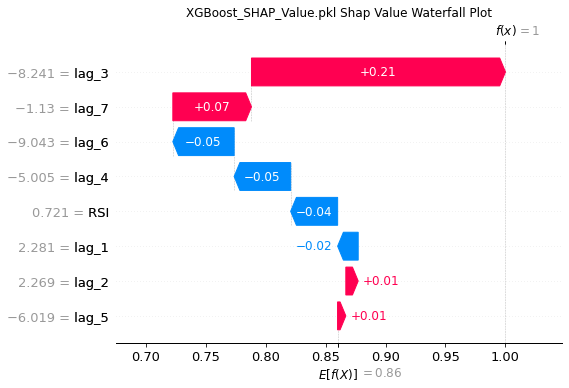

In [35]:
shap_individual_plot(-1)

From here, we can spot that:
1. This data point has a low RSI value of 0.721.
2. RSI = 0.721 will cause the probability of positive returns to drop by 0.04.

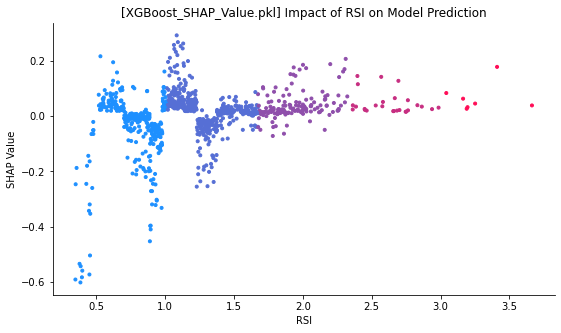

In [36]:
shap_scatter_plot(-1)

We note the following:
1. RSI has a non-linear impact on the model prediction (expected of a tree based model). 
2. A RSI of 0.6 or 1.1 indicates that the next day return will likely be positive.

#### ANN

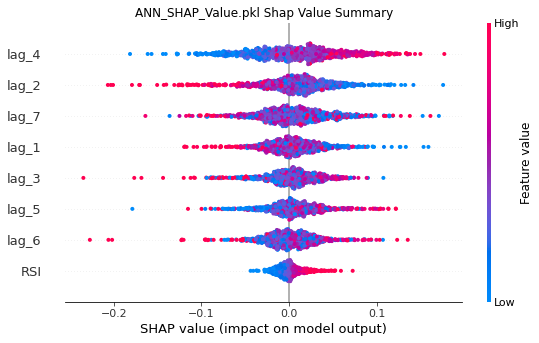

In [37]:
shap_plot(0)

We can spot the following general observations:
1. High RSI value (red) have positive SHAP value (impact on model output)
2. Low RSI value (blue) have negative SHAP value (impact on model outpot)
3. RSI has small SHAP value (impact on model output)

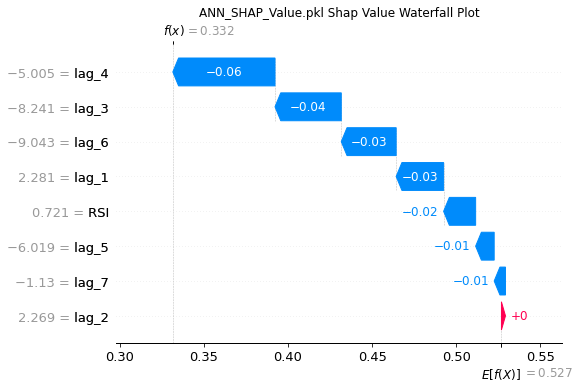

In [38]:
ann_shap = shap.Explanation(all_shap[0].values, all_shap[0].base_values[0][0], all_shap[0].data)
ann_shap.feature_names = x_col

shap.plots.waterfall(ann_shap[0], show=False)
plt.title(f"{all_shap_filename[0]} Shap Value Waterfall Plot")
plt.show()

From here, we can spot that:
1. This data point has a low RSI value of 0.721.
2. RSI = 0.721 will cause the probability of positive returns to drop by 0.02.

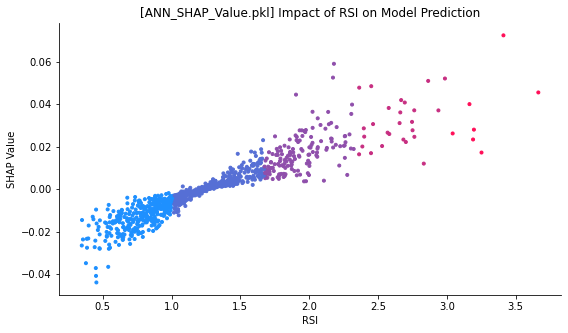

In [39]:
shap_scatter_plot(0)

We note the following:
1. RSI has a linear impact on the model prediction - the higher the RSI, the more likely the next day return will be positive.

#### LSTM

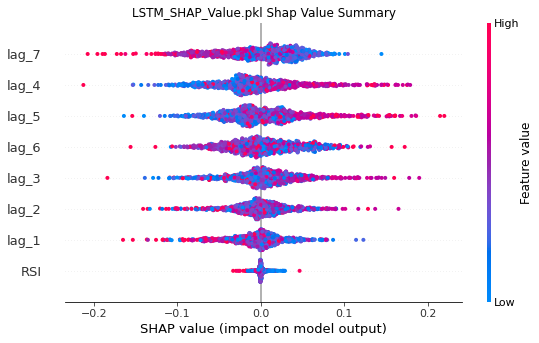

In [40]:
shap_plot(5)

We can spot the following general observations:
1. High RSI value (red) have positive SHAP value (impact on model output)
2. Low RSI value (blue) have negative SHAP value (impact on model outpot)
3. RSI has small SHAP value (impact on model output)

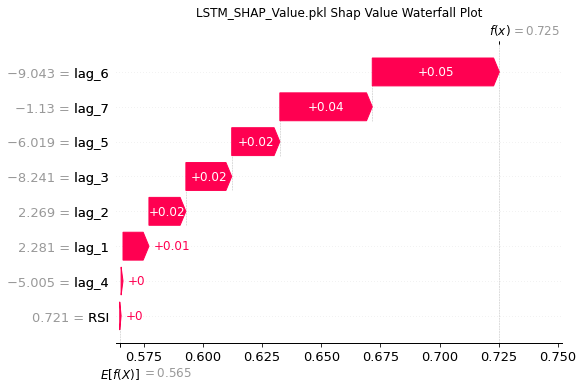

In [41]:
lstm_shap = shap.Explanation(all_shap[5].values, all_shap[5].base_values[0][0], all_shap[5].data)
lstm_shap.feature_names = x_col

shap.plots.waterfall(lstm_shap[0], show=False)
plt.title(f"{all_shap_filename[5]} Shap Value Waterfall Plot")
plt.show()

From here, we can spot that:
1. This data point has a low RSI value of 0.721.
2. RSI = 0.721 will cause the probability of positive returns to drop by 0.02.

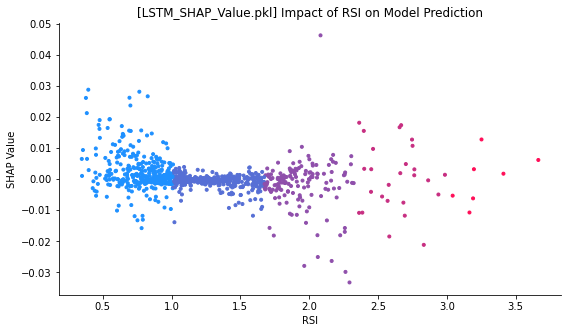

In [42]:
shap_scatter_plot(5)

We note the following:
1. RSI has a weak impact on the model prediction (hovering over a SHAP value of 0)

#### Ensemble Stacking

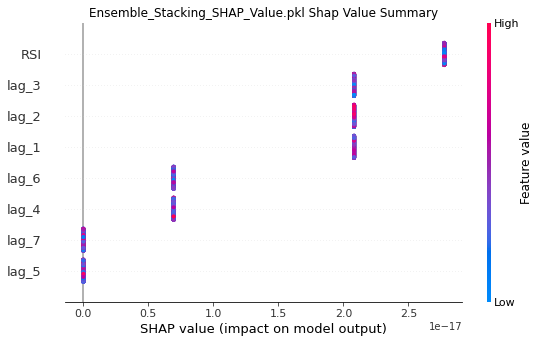

In [43]:
shap_plot(1)

We can spot the following general observations:
1. RSI has a fixed SHAP Value (consistent for both low and high RSI Value)

In [44]:
# shap_individual_plot(1)
# image size is too large

As the impact of RSI on SHAP is constant (regardless of RSI value), we will see the same individual plots for all data points.

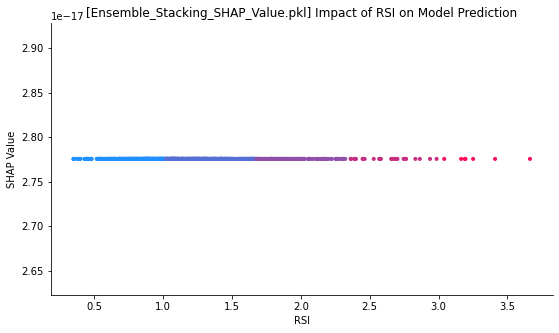

In [45]:
shap_scatter_plot(1)

We note the following:
1. RSI will have a SHAP value of 2.775 regardless of the RSI

Why do we have such an analysis?

This is because the model predicts class 0 for all datapoints. Hence, the impact of of all variables are the same. 

#### Ensemble Voting

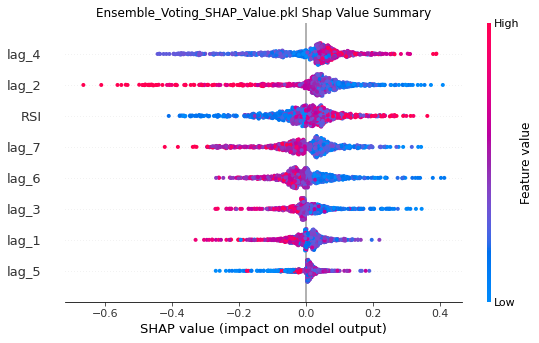

In [46]:
shap_plot(2)

We can spot the following general observations:
1. High RSI value (red) have positive SHAP value (impact on model output)
2. Low RSI value (blue) have negative SHAP value (impact on model outpot)

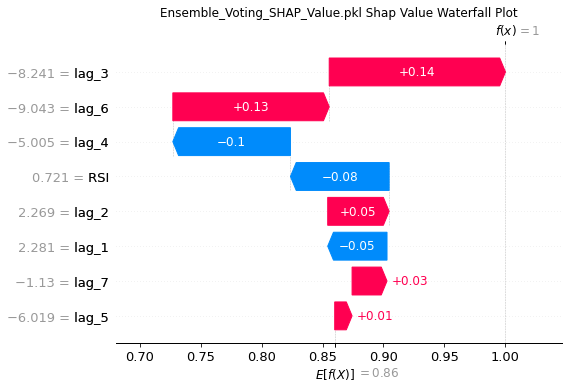

In [47]:
shap_individual_plot(2)

From here, we can spot that:
1. This data point has a low RSI value of 0.721.
2. RSI = 0.721 will cause the probability of positive returns to drop by 0.08.

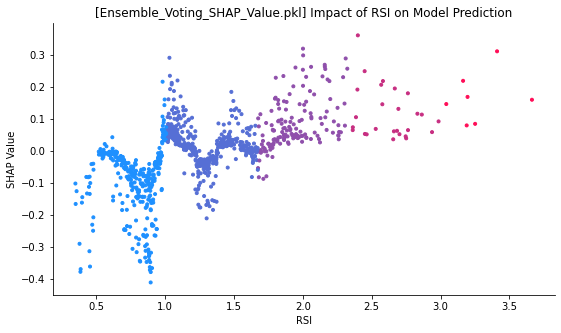

In [48]:
shap_scatter_plot(2)

We note the following:
1. RSI has a non-linear impact on the model prediction.
2. A RSI of 1.1 or higher than 2 indicates that the next day return will likely be positive.

## Using VIX-based RSI measure to generate Alpha

### 1. Test Set Evaluation

In [49]:
read_report("test_compiled_report.csv")

,Test_Accuracy,Test_F1-Score,Test_Precision,Test_ROC_AUC_Score,Test_Recall
ANN,0.520000,0.480000,0.480000,0.520000,0.490000
Ensemble_Stacking,0.540000,0.000000,0.000000,0.520000,0.000000
Ensemble_Voting,0.540000,0.190000,0.480000,0.510000,0.120000
LightGBM,0.540000,0.400000,0.490000,0.510000,0.330000
Logistic,0.520000,0.280000,0.440000,0.490000,0.210000
LSTM,0.490000,0.400000,0.430000,0.490000,0.370000
RandomForest,0.520000,0.030000,0.200000,0.530000,0.020000
XGBoost,0.520000,0.340000,0.470000,0.500000,0.270000


ROC score is preferred as the prediction benchmark does not impact the evaluation. The best model is Random Forest with a score of 0.53.

In [50]:
read_report("backtest_recent_compiled.csv", highlight=False)

,Accumulated_Returns_%,Sharpe_Ratio,Information_Ratio,Sortino_Ratio,Maximum_Drawdown,Volatility
ANN,8.23,0.22,0.93,0.25,9.01,14.91
Ensemble_Stacking,0.0,-inf,0.36,NaN,0.0,0.0
Ensemble_Voting,5.51,0.08,0.63,0.05,4.54,6.76
LightGBM,13.71,0.67,1.16,0.59,7.63,13.13
Logistic,-10.21,-1.34,-0.09,-0.84,9.09,11.41
LSTM,-8.81,-0.85,-0.02,-0.8,8.06,16.37
RandomForest,-2.27,-1.48,0.27,-0.64,4.91,4.94
XGBoost,9.65,0.4,0.91,0.29,6.44,11.95


We see that the Random Forest does not generate the most returns. This is because we optimized the algorithm according to whether the stock price will increase the next day. This algorithm will optimize the "win-rate" (accuracy) but not the degree of the "win". Even though the win rate of the random forest model and the xgboost model are roughly the same, XGBoost model might choose to trade on days where it makes higher returns or lower losses. This is one of the limitation of our strategy.

### 2. Stress Period Evaluation

In [51]:
read_report("stress_compiled_report.csv")

,Accuracy,F1-Score,Precision,ROC_AUC_Score,Recall
ANN,0.480000,0.450000,0.500000,0.450000,0.410000
Ensemble_Stacking,0.490000,0.000000,0.000000,0.520000,0.000000
Ensemble_Voting,0.460000,0.090000,0.350000,0.510000,0.050000
LightGBM,0.480000,0.290000,0.480000,0.510000,0.210000
Logistic,0.470000,0.180000,0.440000,0.480000,0.110000
LSTM,0.510000,0.450000,0.530000,0.520000,0.390000
RandomForest,0.490000,0.050000,0.500000,0.500000,0.020000
XGBoost,0.530000,0.380000,0.590000,0.520000,0.280000


We can see that the model performance changes during the stress period. The best model is XGBoost with a score of 0.52. The previous best model (random forest) has a score of 0.50. This shows that we need rigourous backtesting to ensure that we have sufficient confidence in our strategy.

In [52]:
read_report("backtest_stress_compiled.csv", highlight=False)

,Accumulated_Returns_%,Sharpe_Ratio,Information_Ratio,Sortino_Ratio,Maximum_Drawdown,Volatility
ANN,-22.86,-1.03,0.4,-0.86,20.84,28.34
Ensemble_Stacking,0.0,-inf,0.87,NaN,0.0,0.0
Ensemble_Voting,-14.73,-2.04,0.52,-0.6,9.52,10.08
LightGBM,-32.67,-2.09,0.06,-1.01,21.37,18.83
Logistic,-34.0,-2.35,0.02,-1.25,19.35,17.39
LSTM,-18.64,-1.05,0.49,-0.8,19.17,23.47
RandomForest,2.59,-1.02,0.94,-0.79,1.84,2.23
XGBoost,12.55,0.36,1.42,0.24,13.34,22.96


As mentioned, XGBoost model might choose to trade on days where it makes higher returns or lower losses. Hence, it generates the best returns.